# **TP2**

##*Organización de Datos (75.06/95.58) - Primer Cuatrimestre 2021*

###### Julio de 2021
---

In [ ]:
# Importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# Importamos los archivos de entrada desde google drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1d3bvCoox6nxGIWx81EMEQl_hJ1Y0Jp1q/view?usp=sharing' 
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_values.csv')

train_values=pd.read_csv('train_values.csv', index_col='building_id')

In [ ]:
link = 'https://drive.google.com/file/d/1zsOf_CScGSl6O2CBbgQUX7TH3CALpXbl/view?usp=sharing' 
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_labels.csv')

train_labels=pd.read_csv('train_labels.csv', index_col='building_id')

#Damage grade:
#1 - Low damage
#2 - Medium damage
#3 - Serious damage


In [ ]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

#metric
from sklearn.metrics import f1_score

In [ ]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
cat_cols=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type',
          'position','plan_configuration','legal_ownership_status','geo_level_1_id','geo_level_2_id','geo_level_3_id']
for cc in cat_cols:
    train_values[cc]=train_values[cc].astype('category')

In [ ]:
X_dev = train_values

Y_dev = train_labels['damage_grade'].astype('category')

Y_dev

building_id
802906    3
28830     2
94947     3
590882    2
201944    3
         ..
688636    2
669485    3
602512    3
151409    2
747594    3
Name: damage_grade, Length: 260601, dtype: category
Categories (3, int64): [1, 2, 3]

In [ ]:
from sklearn.model_selection import train_test_split

seed=2

valsize=0.25
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=valsize, random_state=seed)

# Set S1:

In [ ]:
#Numericas
X_train_num=X_train.select_dtypes(exclude='category')
X_train_num=X_train_num[X_train_num.columns.drop(list(X_train_num.filter(like='geo_level')))]
X_train_num=X_train_num[X_train_num.columns.drop(list(X_train_num.filter(like='has_')))]
col1=X_train_num.columns.tolist()

#El resto
col2=X_train.filter(like='type').columns.tolist()
col3=['has_superstructure_mud_mortar_stone','has_superstructure_cement_mortar_brick','has_superstructure_rc_engineered','has_superstructure_rc_non_engineered']
cols=col1+col2+col3+['geo_level_1_id']

In [ ]:
X_train_subset = X_train[cols]
X_val_subset = X_val[cols]

#Drop count_floors
X_train_subset = X_train_subset.drop(columns=['count_floors_pre_eq'])
X_val_subset = X_val_subset.drop(columns=['count_floors_pre_eq'])

X_train_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 13 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   age                                     195450 non-null  int64   
 1   area_percentage                         195450 non-null  int64   
 2   height_percentage                       195450 non-null  int64   
 3   count_families                          195450 non-null  int64   
 4   foundation_type                         195450 non-null  category
 5   roof_type                               195450 non-null  category
 6   ground_floor_type                       195450 non-null  category
 7   other_floor_type                        195450 non-null  category
 8   has_superstructure_mud_mortar_stone     195450 non-null  int64   
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64   
 10  has_superstructure_rc_engin

## Probamos el encoding para geo_level_1_id

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

### Sin geo_level_1_id: CatBoost

In [ ]:
X_train_subset_0=X_train_subset.drop(columns='geo_level_1_id')
X_val_subset_0=X_val_subset.drop(columns='geo_level_1_id')
X_train_subset_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 12 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   age                                     195450 non-null  int64   
 1   area_percentage                         195450 non-null  int64   
 2   height_percentage                       195450 non-null  int64   
 3   count_families                          195450 non-null  int64   
 4   foundation_type                         195450 non-null  category
 5   roof_type                               195450 non-null  category
 6   ground_floor_type                       195450 non-null  category
 7   other_floor_type                        195450 non-null  category
 8   has_superstructure_mud_mortar_stone     195450 non-null  int64   
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64   
 10  has_superstructure_rc_engin

In [ ]:
model = CatBoostClassifier(cat_features=X_train_subset_0.select_dtypes('category').columns,iterations=500, logging_level='Silent')
model.fit(X_train_subset_0, Y_train)
Y_pred = model.predict(X_val_subset_0)
f1_val=f1_score(Y_val, Y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.5889241914936072


Text(0.5, 1.0, 'CatBoost: set S1 sin $geo\\_level\\_1\\_id$')

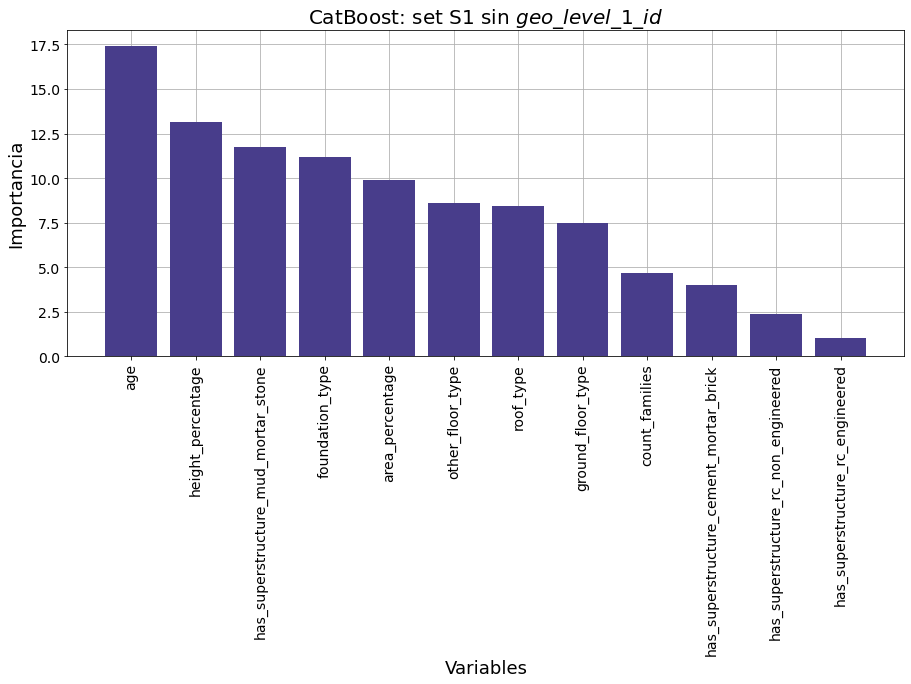

In [ ]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_subset_0.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(15,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S1 sin $geo\_level\_1\_id$',fontsize=20)

###  Sin encodear geo_level_1_id: CatBoost

In [28]:
X_train_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 13 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   age                                     195450 non-null  int64   
 1   area_percentage                         195450 non-null  int64   
 2   height_percentage                       195450 non-null  int64   
 3   count_families                          195450 non-null  int64   
 4   foundation_type                         195450 non-null  category
 5   roof_type                               195450 non-null  category
 6   ground_floor_type                       195450 non-null  category
 7   other_floor_type                        195450 non-null  category
 8   has_superstructure_mud_mortar_stone     195450 non-null  int64   
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64   
 10  has_superstructure_rc_engin

In [29]:
model = CatBoostClassifier(cat_features=X_train_subset.select_dtypes('category').columns,iterations=500, logging_level='Silent')
model.fit(X_train_subset, Y_train)
Y_pred = model.predict(X_val_subset)
f1_val=f1_score(Y_val, Y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.6841491304814968


[ 9.7032883   5.71618715  6.50518347  2.18893435  6.01691342  7.47301477
  6.25526917  6.10047164  5.17549241  1.68987131  0.28654654  0.72366497
 42.1651625 ]


Text(0.5, 1.0, 'CatBoost: set S1 sin encodear $geo\\_level\\_1\\_id$')

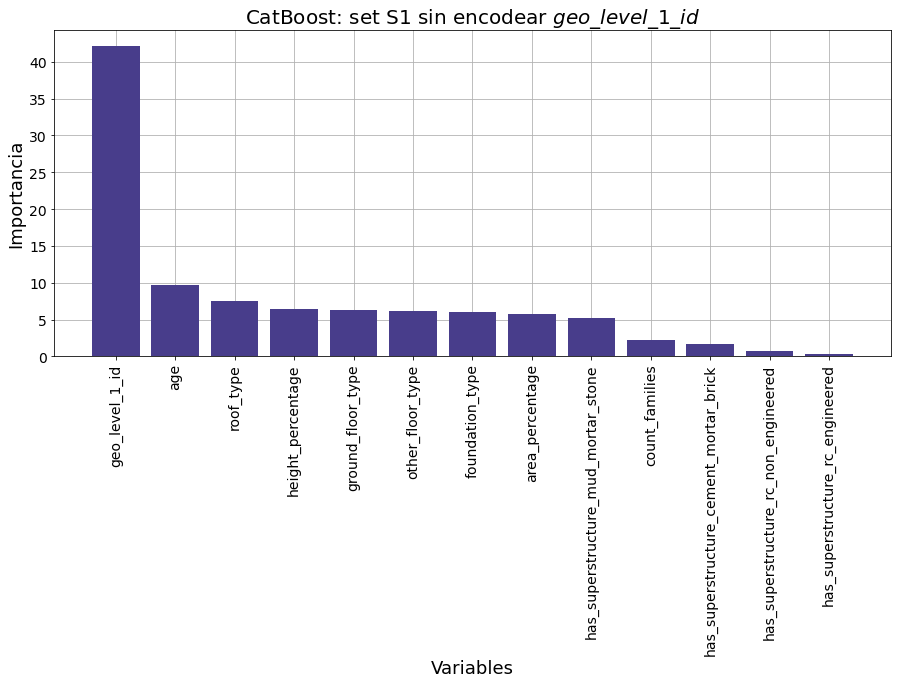

In [30]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_subset.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(15,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S1 sin encodear $geo\_level\_1\_id$',fontsize=20)

### Encodeando geo_level_1_id: Catboost



In [ ]:
X_train_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 13 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   age                                     195450 non-null  int64   
 1   area_percentage                         195450 non-null  int64   
 2   height_percentage                       195450 non-null  int64   
 3   count_families                          195450 non-null  int64   
 4   foundation_type                         195450 non-null  category
 5   roof_type                               195450 non-null  category
 6   ground_floor_type                       195450 non-null  category
 7   other_floor_type                        195450 non-null  category
 8   has_superstructure_mud_mortar_stone     195450 non-null  int64   
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64   
 10  has_superstructure_rc_engin

Encodeamos geo_level_1_id en 3 columnas: fracción de casas en ese geo_level_1_id con daño 1/2/3

In [ ]:
df_0=X_train_subset.merge(Y_train, left_index=True, right_index=True, how='inner')
df=df_0[['damage_grade','geo_level_1_id']].copy().set_index(['damage_grade','geo_level_1_id'])
df['countingindex']=1
df=df.groupby(['damage_grade','geo_level_1_id']).agg({'countingindex':'sum'}).unstack().droplevel(0,axis=1).fillna(0)
df

geo_level_1_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
damage_grade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,246.0,325.0,57.0,184.0,384.0,347.0,1566.0,778.0,489.0,422.0,928.0,279.0,149.0,1453.0,146.0,118.0,146.0,217.0,50.0,33.0,2523.0,239.0,571.0,56.0,202.0,361.0,6054.0,356.0,0.0,7.0,186.0
2,2288.0,1490.0,467.0,3408.0,8299.0,1535.0,12203.0,8557.0,6415.0,2060.0,9104.0,3487.0,1701.0,4650.0,967.0,1286.0,2448.0,2939.0,583.0,182.0,8885.0,4392.0,3415.0,580.0,664.0,3263.0,9452.0,4557.0,112.0,255.0,1594.0
3,445.0,223.0,181.0,2051.0,2143.0,171.0,4562.0,5048.0,7384.0,497.0,6544.0,2375.0,518.0,1005.0,197.0,356.0,711.0,13232.0,1762.0,49.0,1523.0,6528.0,624.0,205.0,91.0,580.0,1484.0,4517.0,74.0,28.0,232.0


In [ ]:
frac_df=np.divide(np.array(df.iloc[0]),np.array(df.sum(axis=0)))
frac_df=pd.concat([pd.Series(frac_df), pd.Series(np.divide(np.array(df.iloc[1]),np.array(df.sum(axis=0))))],axis=1,keys=['1','2'])
frac_df=pd.concat([frac_df, pd.Series(np.divide(np.array(df.iloc[2]),np.array(df.sum(axis=0))))],axis=1)
frac_df=frac_df.rename(columns={0:'3'})
frac_df

,1,2,3
0,0.082578,0.768043,0.149379
1,0.159470,0.731109,0.109421
2,0.080851,0.662411,0.256738
3,0.032607,0.603934,0.363459
4,0.035470,0.766580,0.197949
5,0.169021,0.747686,0.083293
6,0.085429,0.665703,0.248868
7,0.054092,0.594938,0.350970
8,0.034225,0.448978,0.516797
9,0.141658,0.691507,0.166835


In [ ]:
X_train_subset.head()

,age,area_percentage,height_percentage,count_families,foundation_type,roof_type,ground_floor_type,other_floor_type,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_rc_engineered,has_superstructure_rc_non_engineered,geo_level_1_id
building_id,,,,,,,,,,,,,
984478,20,8,5,1,r,q,f,q,1,0,0,0,10
33931,20,6,9,1,r,n,f,q,1,0,0,0,21
599202,20,6,4,1,r,n,f,q,1,0,0,0,17
692573,20,12,6,0,r,q,f,q,1,0,0,0,21
719424,10,8,5,1,r,n,f,q,1,1,0,0,26


In [ ]:
print(X_train_subset.shape)
X_train_subset_enc=X_train_subset.merge(frac_df,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_train_subset_enc=X_train_subset_enc.drop(columns='geo_level_1_id')
print(X_train_subset_enc.shape)
X_train_subset_enc.head()

(195450, 13)
(195450, 15)


,age,area_percentage,height_percentage,count_families,foundation_type,roof_type,ground_floor_type,other_floor_type,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_rc_engineered,has_superstructure_rc_non_engineered,Frac_damage_1,Frac_damage_2,Frac_damage_3
building_id,,,,,,,,,,,,,,,
984478,20,8,5,1,r,q,f,q,1,0,0,0,0.055985,0.549228,0.394788
33931,20,6,9,1,r,n,f,q,1,0,0,0,0.021418,0.393584,0.584999
599202,20,6,4,1,r,n,f,q,1,0,0,0,0.013241,0.179339,0.807420
692573,20,12,6,0,r,q,f,q,1,0,0,0,0.021418,0.393584,0.584999
719424,10,8,5,1,r,n,f,q,1,1,0,0,0.356327,0.556327,0.087345


In [ ]:
print(X_val_subset.shape)
X_val_subset_enc=X_val_subset.merge(frac_df,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_val_subset_enc=X_val_subset_enc.drop(columns='geo_level_1_id')
print(X_val_subset_enc.shape)
X_val_subset_enc.head()

(65151, 13)
(65151, 15)


,age,area_percentage,height_percentage,count_families,foundation_type,roof_type,ground_floor_type,other_floor_type,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_rc_engineered,has_superstructure_rc_non_engineered,Frac_damage_1,Frac_damage_2,Frac_damage_3
building_id,,,,,,,,,,,,,,,
624213,5,6,7,1,r,n,f,q,1,0,0,0,0.085429,0.665703,0.248868
393391,20,8,5,1,r,n,x,q,1,0,0,0,0.000000,0.602151,0.397849
615537,30,3,6,0,r,n,f,q,1,0,0,0,0.034225,0.448978,0.516797
351011,70,11,6,1,r,q,f,x,1,0,0,0,0.169021,0.747686,0.083293
638354,5,16,12,2,u,x,v,s,0,1,0,1,0.013241,0.179339,0.807420


In [ ]:
X_train_subset_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 15 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   age                                     195450 non-null  int64   
 1   area_percentage                         195450 non-null  int64   
 2   height_percentage                       195450 non-null  int64   
 3   count_families                          195450 non-null  int64   
 4   foundation_type                         195450 non-null  category
 5   roof_type                               195450 non-null  category
 6   ground_floor_type                       195450 non-null  category
 7   other_floor_type                        195450 non-null  category
 8   has_superstructure_mud_mortar_stone     195450 non-null  int64   
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64   
 10  has_superstructure_rc_engin

In [ ]:
model = CatBoostClassifier(cat_features=X_train_subset_enc.select_dtypes('category').columns,iterations=500, logging_level='Silent')
model.fit(X_train_subset_enc, Y_train)
Y_pred = model.predict(X_val_subset_enc)
f1_val=f1_score(Y_val, Y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.6860524013445688


Text(0.5, 1.0, 'CatBoost: set S1 encodeando $geo\\_level\\_1\\_id$')

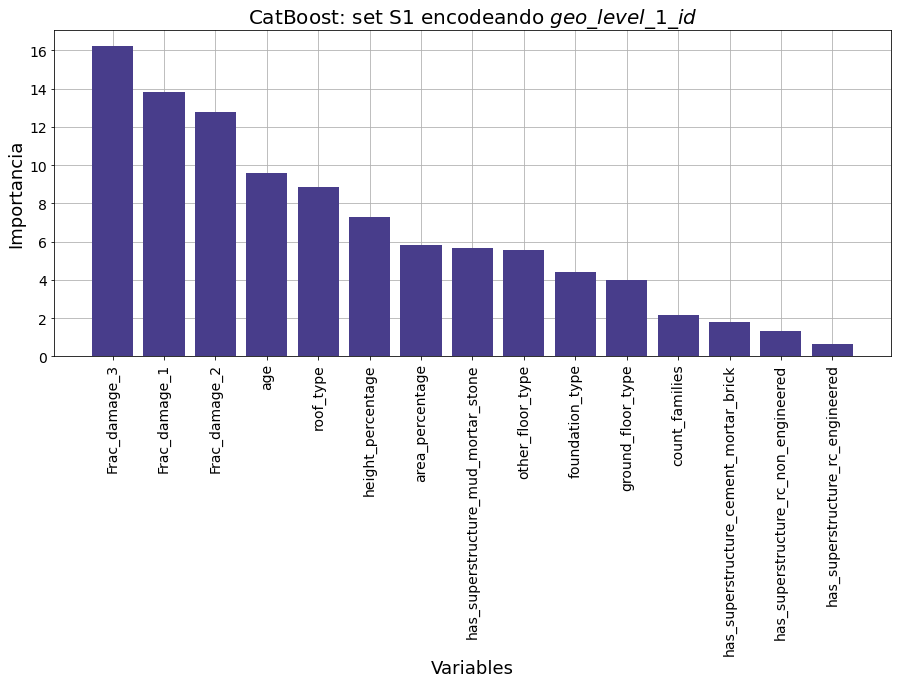

In [ ]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_subset_enc.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(15,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'CatBoost: set S1 encodeando $geo\_level\_1\_id$',fontsize=20)